# Neo4j Runway: End-to-End Graph Creation Example



## Introduction
This notebook demonstrates how to use Neo4j Runway to:
* use an LLM to generate a graph data model from a CSV,
* generate Cypher code to load the .csv data into a Neo4j Graph Database. 

Neo4j Runway is an open source library created by my colleague [Alex Gilmore](https://medium.com/@a-gilmore). You can find the [repo here](https://github.com/a-s-g93/neo4j-runway) and a blog describing the library [here](https://medium.com/neo4j/easy-data-ingestion-with-neo4j-runway-and-arrows-app-1e5f121333a7).

As you will see in the notebook, all of this is performed **without writing a single line of Cypher.** This demonstrates the promise of using LLMs to faciliate graph generation and graph loading. 

Additionally, it is important to remember that Neo4j makes it easy to iterate on your graph data model. The goal of Neo4j Runway is to help you get started with something that is close to your final data model so that you can start working with the data as a graph as quickly as possible. We find that many of the finishing touches on a graph data model can only come once you are working with the data in a graph database. Tools like Neo4j runway get you from tabular data to working graph database quickly. 

*Note: Neo4j Runway is in early stages of development. It is also an open source project and not officially supported by Neo4j.*

## Install and Import Libraries

*Note: Currently, Neo4j Runway requires that graphviz is installed on your machine. We are exploring alternatives that do not require this step.*

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# !pip install graphviz --quiet --upgrade
# !pip install neo4j_runway --upgrade --quiet
from neo4j_runway import Discovery, GraphDataModeler, IngestionGenerator, LLM, PyIngest


In [3]:
# !pip install python-dotenv --upgrade --quiet
from dotenv import load_dotenv

import os

In [4]:
# function to print markdown
from IPython.display import display, Markdown
def print_markdown(text):
    display(Markdown(text))

## Load Environment Variables
We will need an OpenAI API key along with the URL and Password for the Neo4j database. These are stored in a local `.env` file.

In [ ]:
# read in from .env file
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
NEO4J_URL = os.getenv('NEO4J_URL')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')

## Load and Explore Data
For this example we will use the record of bank failures in the United States. This data is published by the Federal Deposit Insurance Corporation (FDIC) and is available at https://www.fdic.gov/bank/individual/failed/banklist.csv. 

This data was new to me as I worked on this notebook, so I did not know what it contained or what a potential graph data model might look like. This is a good test for the LLM to see if it can generate a useful graph data model.

In [28]:
# read data directly into a dataframe 
failedBank_df = pd.read_csv('https://www.fdic.gov/bank/individual/failed/banklist.csv', encoding='ISO-8859-1')
failedBank_df.shape

(569, 7)

In [29]:
failedBank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Bank Name               569 non-null    object
 1   City                    569 non-null    object
 2   State                   569 non-null    object
 3   Cert                    569 non-null    int64 
 4   Acquiring Institution   569 non-null    object
 5   Closing Date            569 non-null    object
 6   Fund                    569 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 31.2+ KB


In [30]:
failedBank_df.head()

,Bank Name,City,State,Cert,Acquiring Institution,Closing Date,Fund
0,Republic First Bank dba Republic Bank,Philadelphia,PA,27332,"Fulton Bank, National Association",26-Apr-24,10546
1,Citizens Bank,Sac City,IA,8758,Iowa Trust & Savings Bank,3-Nov-23,10545
2,Heartland Tri-State Bank,Elkhart,KS,25851,"Dream First Bank, N.A.",28-Jul-23,10544
3,First Republic Bank,San Francisco,CA,59017,"JPMorgan Chase Bank, N.A.",1-May-23,10543
4,Signature Bank,New York,NY,57053,"Flagstar Bank, N.A.",12-Mar-23,10540


## Preprocess Data
The data contained spaces in the column names. Additionally, all data currently needs to be strings to be loaded into the data model, so we will take care of that first. 

In [8]:
# trim whitepace from column names
failedBank_df.columns = failedBank_df.columns.str.strip()
failedBank_df.columns

Index(['Bank Name', 'City', 'State', 'Cert', 'Acquiring Institution',
       'Closing Date', 'Fund'],
      dtype='object')

In [9]:
# convert all columns to strings
failedBank_df['Cert'] = failedBank_df['Cert'].astype(str)
failedBank_df['Closing Date'] = failedBank_df['Closing Date'].astype(str)
failedBank_df['Fund'] = failedBank_df['Fund'].astype(str)

In [11]:
# write to .csv 
failedBank_df.to_csv('data/failedBank.csv', index=False)

## Describe Data
In this section we need to create a key-value pairs describing the features of our data:
* The first entry should be titled 'general_description' and provide a high-level overview of the data. 
* Each subsequent entry should correspond to a feature in the data. 

In [14]:
DATA_DESCRIPTION = {
    'general_description': 'This dataset provides a list of failed banks in the United States.',
    'Bank Name': 'Name of the failed bank.',
    'City': 'City where the failed bank was headquartered.',
    'State': 'State where the failed bank was headquartered.',
    'Cert': 'FDIC certificate number of the failed bank.',
    'Acquiring Institution': 'Name of the institution that acquired the failed bank.',
    'Closing Date': 'Date that the failed bank closed.',
    'Fund': 'FDIC fund number of the failed bank, which acts as a unique identifier in this data set.',
}

## Analyze Tabular Data with an LLM
Before asking the LLM to generate a data model, we will first ask it to analyze the tabular data. This will identify statistical and categorical elements of the data that are important for generating a graph data model.

In [15]:
# instantiate llm, which defaults to OpenAI GPT-4o
llm = LLM()

In [16]:
# pass data and descriptions to LLM
disc = Discovery(llm=llm, user_input=DATA_DESCRIPTION, data=failedBank_df)
disc.run()

'Based on the provided summary of the dataset, here is a preliminary analysis:\n\n### Overall Details:\n1. **Data Size and Structure**:\n   - The dataset contains 569 entries (rows) and 7 columns.\n   - All columns are of type `object`, which means they are treated as strings in pandas.\n\n2. **Missing Values**:\n   - There are no missing values in the dataset, as indicated by the non-null count being equal to the total number of entries for each column.\n\n3. **Unique Values**:\n   - The dataset has a mix of columns with high cardinality (many unique values) and columns with lower cardinality (fewer unique values).\n\n### Feature Analysis:\n1. **Bank Name**:\n   - There are 551 unique bank names out of 569 entries.\n   - The most frequent bank name is "The First State Bank," which appears 3 times.\n   - This column is important for identifying individual banks.\n\n2. **City**:\n   - There are 436 unique cities.\n   - The most frequent city is Chicago, with 20 occurrences.\n   - This c

In [14]:
print_markdown(disc.discovery)

Based on the provided summary of the dataset, here is a preliminary analysis:

### Overall Details:
1. **Data Size and Structure**:
   - The dataset contains 569 entries and 7 columns.
   - All columns are of type `object`, indicating that they are likely categorical or string data.

2. **Missing Values**:
   - There are no missing values in the dataset, as all columns have 569 non-null entries.

3. **Unique Values**:
   - The dataset has a mix of columns with high and low cardinality (number of unique values).

### Feature Analysis:
1. **Bank Name**:
   - There are 551 unique bank names out of 569 entries.
   - The most frequent bank name is "The First State Bank," appearing 3 times.
   - This feature is important for identifying individual banks.

2. **City**:
   - There are 436 unique cities.
   - The most frequent city is Chicago, with 20 occurrences.
   - This feature can help in geographical analysis of bank failures.

3. **State**:
   - There are 44 unique states.
   - The most frequent state is Georgia (GA), with 93 occurrences.
   - This feature is crucial for state-level analysis of bank failures.

4. **Cert**:
   - Each entry has a unique FDIC certificate number (569 unique values).
   - This feature acts as a unique identifier for each bank and is essential for precise identification.

5. **Acquiring Institution**:
   - There are 303 unique acquiring institutions.
   - The most frequent value is "No Acquirer," appearing 31 times.
   - This feature is important for understanding the aftermath of bank failures and the institutions involved in acquisitions.

6. **Closing Date**:
   - There are 264 unique closing dates.
   - The most frequent closing date is "30-Oct-09," with 9 occurrences.
   - This feature is important for temporal analysis and understanding trends over time.

7. **Fund**:
   - Each entry has a unique FDIC fund number (569 unique values).
   - This feature acts as another unique identifier and is crucial for precise identification.

### Important Features:
1. **Bank Name** and **Cert**:
   - Both are critical for identifying individual banks. "Cert" is particularly important as it is unique for each bank.

2. **State** and **City**:
   - These features are important for geographical analysis and understanding regional patterns in bank failures.

3. **Acquiring Institution**:
   - This feature provides insights into the institutions involved in acquiring failed banks, which can be important for understanding the market dynamics and consolidation trends.

4. **Closing Date**:
   - This feature is essential for temporal analysis, helping to identify trends and patterns over time.

5. **Fund**:
   - Acts as a unique identifier, similar to "Cert," and is important for precise identification.

### Summary:
The dataset provides a comprehensive overview of failed banks in the United States, with detailed information on their names, locations, acquisition details, and closing dates. The most important features for analysis include "Bank Name," "Cert," "State," "City," "Acquiring Institution," and "Closing Date." These features will be crucial for any further analysis, including geographical, temporal, and market dynamics studies.

## Use LLM to Create Initial Data Model
Now that we have analyzed the statistical and categorical features of the data, we can have the LLM generate an initial data model. This initial data model will point is in the right direction, but is unlikely to be perfect. That is perfectly fine because we can continue iterating it using the LLM and then once we have the data in Neo4j. The objective is to get from the tabular data to the start of a graph data model as quickly as possible.

*Note: As of version 0.41 Neo4j Runway uses graphviz, which requires the graphviz package to be installed locally as well as in the Python environment.* 

In [20]:
# instantiate graph data modeler 
gdm = GraphDataModeler(llm=llm, discovery=disc)

# generate model 
gdm.create_initial_model()

recieved a valid response


DataModel(nodes=[Node(label='Bank', properties=[Property(name='bankName', type='str', csv_mapping='Bank Name', csv_mapping_other=None, is_unique=True, part_of_key=False), Property(name='cert', type='str', csv_mapping='Cert', csv_mapping_other=None, is_unique=False, part_of_key=False)], csv_name=''), Node(label='Location', properties=[Property(name='city', type='str', csv_mapping='City', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='state', type='str', csv_mapping='State', csv_mapping_other=None, is_unique=False, part_of_key=False)], csv_name=''), Node(label='AcquiringInstitution', properties=[Property(name='acquiringInstitution', type='str', csv_mapping='Acquiring Institution', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='Closure', properties=[Property(name='closingDate', type='str', csv_mapping='Closing Date', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='fund', type='str', csv_mappin

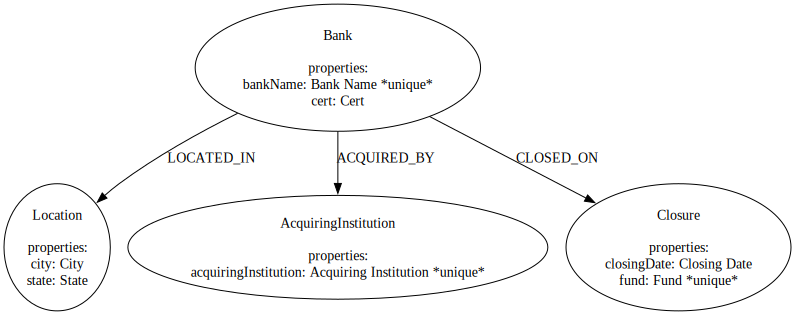

In [21]:
# visualize the data model
gdm.current_model.visualize()

## Iterate the Data Model 
Once we see the initial model we can suggest corrections. It is a best practice to make these suggestions as clear and direct as possible.

recieved a valid response


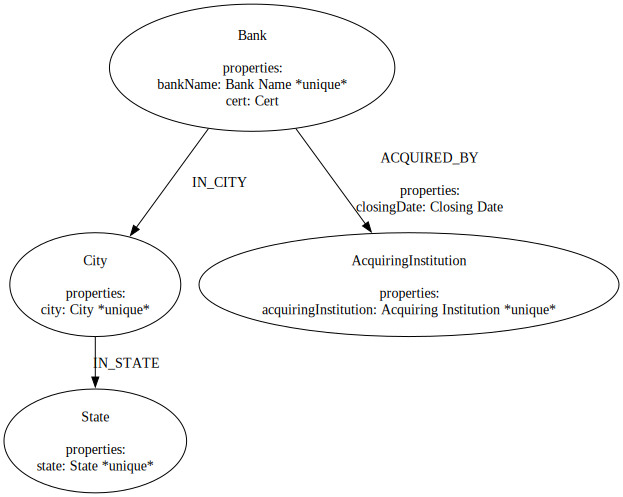

In [22]:
gdm.iterate_model(user_corrections='''
This is a good start. Please make the following updates to the data model:
1. Remove the Closure node from the data model. Add the closingDate property to the ACQUIRED_BY relationship. We will discard Fund and not use it.
2. Change the Location node to be a City node, with the property city which must be unique.
3. Change the LOCATED_IN relationship to be named IN_CITY. It will originate from the Bank node and connect to the City node.
4. Make State its own node with the property state, which must be unique. 
5. Add an IN_STATE relationship to the graph. It will originate from the City node and connect to the State node.
''')

# visualize the updated data model
gdm.current_model.visualize()

## Generate Ingestion Code
Once we have a graph data model that we are happy with, we can generate the Cypher code and YAML file to load the data into Neo4j.

In [23]:
# instantiate ingestion generator
gen = IngestionGenerator(data_model=gdm.current_model, 
                         username="neo4j", 
                         password=NEO4J_PASSWORD,
                         uri=NEO4J_URL,
                         database="neo4j", 
                         csv_dir="data/", 
                         csv_name="failedBank.csv")


In [26]:
# create ingestion YAML 
pyingest_yaml = gen.generate_pyingest_yaml_string()

# print(pyingest_yaml)

In [27]:
# save local copy of YAML
gen.generate_pyingest_yaml_file(file_name="failedBanks")


## Load Data into Neo4j 
The last step is to load the data into Neo4j. From there we can explore the data in Neo4j itself or by using one of the Neo4j Python connectors. 

In [25]:
PyIngest(yaml_string=pyingest_yaml, dataframe=failedBank_df)

File {} .//data/failedBank.csv
loading... 0 2024-06-12 14:28:14.301519


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 1 2024-06-12 14:28:14.522532
loading... 2 2024-06-12 14:28:14.645311
loading... 3 2024-06-12 14:28:14.751105
loading... 4 2024-06-12 14:28:14.848752
{} : Completed file 2024-06-12 14:28:14.946076
File {} .//data/failedBank.csv
loading... 0 2024-06-12 14:28:14.947898
loading... 1 2024-06-12 14:28:15.123889


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 2 2024-06-12 14:28:15.237596
loading... 3 2024-06-12 14:28:15.323707
loading... 4 2024-06-12 14:28:15.414296
{} : Completed file 2024-06-12 14:28:15.493120
File {} .//data/failedBank.csv
loading... 0 2024-06-12 14:28:15.495728
loading... 1 2024-06-12 14:28:15.645882


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 2 2024-06-12 14:28:15.723272
loading... 3 2024-06-12 14:28:15.800584
loading... 4 2024-06-12 14:28:15.874852
{} : Completed file 2024-06-12 14:28:15.949498
File {} .//data/failedBank.csv
loading... 0 2024-06-12 14:28:15.951495
loading... 1 2024-06-12 14:28:16.082499


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 2 2024-06-12 14:28:16.160348
loading... 3 2024-06-12 14:28:16.238493
loading... 4 2024-06-12 14:28:16.319103
{} : Completed file 2024-06-12 14:28:16.396003
File {} .//data/failedBank.csv
loading... 0 2024-06-12 14:28:16.398105


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 1 2024-06-12 14:28:16.631287
loading... 2 2024-06-12 14:28:16.777422
loading... 3 2024-06-12 14:28:16.883538
loading... 4 2024-06-12 14:28:16.973758
{} : Completed file 2024-06-12 14:28:17.058690
File {} .//data/failedBank.csv
loading... 0 2024-06-12 14:28:17.060160
loading... 1 2024-06-12 14:28:17.240423


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 2 2024-06-12 14:28:17.335698
loading... 3 2024-06-12 14:28:17.414711
loading... 4 2024-06-12 14:28:17.495998
{} : Completed file 2024-06-12 14:28:17.583840
File {} .//data/failedBank.csv
loading... 0 2024-06-12 14:28:17.586211
loading... 1 2024-06-12 14:28:17.740729


/opt/anaconda3/envs/llm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 2 2024-06-12 14:28:17.834014
loading... 3 2024-06-12 14:28:17.927048
loading... 4 2024-06-12 14:28:18.020775
{} : Completed file 2024-06-12 14:28:18.110221


## Conclusion
In this notebook we demonstrated how to use Neo4j Runway to explore a new tabular dataset, generate a graph data model, and load the data into Neo4j. This process is designed to be iterative and to get you from tabular data to a working graph database as quickly as possible.

Neo4j Runway is an open source project under active development and we welcome contributions and feedback.